# Q4 – MMM01 vs MMM02 (Mean-Reversion Market Maker) in Synthetic and Nasdaq Markets

This notebook implements Question 4 of the INFT coursework.

We compare:
- **MMM01**: baseline market-maker (from Q3)
- **MMM02**: modified *mean-reversion* market-maker

under **strictly controlled conditions**:
- same synthetic CDA market as in Q3
- same Nasdaq-offset market as in Q3 (offset-nasdaq-1m-170913.csv)
- same trader population (ZIC, ZIP, SHVR, SNPR, PRZI, plus one market-maker)
- same MMM parameters (n_past_trades, bid_percent, ask_delta) for both MMM01 and MMM02
- same session length and random seeds per market/run

The only difference between the two treatments is the **market-maker algorithm**.


In [1]:
import os
import csv
import math
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import BSE
from BSE import offset_from_file  # used for the Nasdaq-based offset schedule

BASE_SEED = 12345
Q4DATA_DIR = "Q4data"
os.makedirs(Q4DATA_DIR, exist_ok=True)

# tqdm for progress bars
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# Session timing (same as Q3)
START_TIME = 0
END_TIME = 60 * 15  

print("Imports OK, data dir:", Q4DATA_DIR)


Imports OK, data dir: Q4data


## Parameter block: MMM01* configuration, markets, and IID runs

- `MMM_PARAMS` should be set to the **best-performing MMM01* configuration from Q3**.
- `MARKET_IDS` should list:
  - one synthetic CDA market (same as your main synthetic market in Q3)
  - one Nasdaq-based offset market (e.g., using `offset-nasdaq-1m-170913`).
- The number of IID runs per market should be large enough (e.g. 30–50) for hypothesis testing.
- The trader population (other trader types, numbers) should match your Q3 setup, except
  that we switch between MMM01 and MMM02.


In [2]:
# MMM01* parameters selected from Q3 (you can change these if needed)
MMM_PARAMS = {
    "n_past_trades": 7,    # your best configuration from Q3: 8 / 0.96 / 12
    "bid_percent": 0.97,
    "ask_delta": 10,
}

# Markets to test (controlled to match Q3)
MARKETS = ["synthetic", "nasdaq"]

# IID runs per market per MM version (adjust if runtime is too long)
N_RUNS_PER_MARKET = 30  # e.g. 30 or 50 runs

print("MMM parameters:", MMM_PARAMS)
print("Markets:", MARKETS)
print("Runs per market:", N_RUNS_PER_MARKET)


MMM parameters: {'n_past_trades': 7, 'bid_percent': 0.97, 'ask_delta': 10}
Markets: ['synthetic', 'nasdaq']
Runs per market: 30


In [3]:
# ---------- Synthetic market (same as Q3) ----------

def make_virtual_order_schedule(start_time=START_TIME, end_time=END_TIME):
    """
    Synthetic CDA market: random supply and demand ranges with overlap.
    This matches the Q3 synthetic configuration.
    """
    sup_range = (150, 200)
    dem_range = (170, 220)

    supply_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [sup_range],
        "stepmode": "random",
    }]
    demand_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [dem_range],
        "stepmode": "random",
    }]

    order_sched = {
        "sup": supply_schedule,
        "dem": demand_schedule,
        "interval": 30,
        "timemode": "drip-jitter",
    }
    return order_sched


# ---------- Nasdaq-offset market (same as Q3) ----------

NASDAQ_CSV_PATH = "offset-nasdaq-1m-170913.csv"
TIME_COL = 1    # column index for time in the CSV
PRICE_COL = 5   # column index for price in the CSV
SCALE_FACTOR = 75.0  # scale factor used in Q3

def build_nasdaq_offset(end_time=END_TIME):
    """
    Build a time-dependent price offset from the Nasdaq 1-minute data.
    """
    offset_fn = offset_from_file(
        price_offset_filename=NASDAQ_CSV_PATH,
        time_col=TIME_COL,
        price_col=PRICE_COL,
        scale_factor=SCALE_FACTOR,
        end_time=end_time,
    )
    return offset_fn

nasdaq_offset = build_nasdaq_offset()

def make_nasdaq_order_schedule(offset, start_time=START_TIME, end_time=END_TIME):
    """
    Nasdaq-based CDA market: base ranges shifted by a time-varying offset.
    This matches the Q3 Nasdaq configuration.
    """
    # overlap of supply & demand (base ranges before offset)
    base_sup_range = (120, 220)
    base_dem_range = (180, 280)

    sup_range = (base_sup_range[0], base_sup_range[1], offset)
    dem_range = (base_dem_range[0], base_dem_range[1], offset)

    supply_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [sup_range],
        "stepmode": "random",
    }]
    demand_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [dem_range],
        "stepmode": "random",
    }]

    order_sched = {
        "sup": supply_schedule,
        "dem": demand_schedule,
        "interval": 10,
        "timemode": "drip-jitter",
    }
    return order_sched


# ---------- Seeds: keep random structure controlled (matching Q3 pattern) ----------

def get_seed(market_id, run_id):
    """
    Returns a deterministic random seed for each (market_id, run_id).
    We follow the same structure as in Q3, so the environment is comparable.
    """
    if market_id == "synthetic":
        return BASE_SEED + run_id
    elif market_id == "nasdaq":
        return BASE_SEED + 10_000 + run_id
    else:
        raise ValueError(f"Unknown market_id: {market_id}")


In [4]:
def make_traders_spec(mm_version, mmm_params, n_each_type=5):
    """
    Build the trader population for a given market-maker version.

    Population is kept identical to Q3:
    - Buyers: ZIC, ZIP, SHVR, SNPR, PRZI
    - Sellers: ZIC, ZIP, SHVR, SNPR, PRZI
    - Market-maker: one MMM (either MMM01 or MMM02) with the same mmm_params

    The only difference between treatments is the market-maker algorithm.
    """
    trader_types_simple = ["ZIC", "ZIP", "SHVR", "SNPR"]

    buyers_spec = []
    sellers_spec = []

    # symmetric simple traders
    for t in trader_types_simple:
        buyers_spec.append((t, n_each_type))
        sellers_spec.append((t, n_each_type))

    # PRZI parameters (same for buyers and sellers)
    przi_params = {
        "s_min": -1.0,
        "s_max": 1.0,
        "k": 1,
    }
    buyers_spec.append(("PRZI", n_each_type, przi_params))
    sellers_spec.append(("PRZI", n_each_type, przi_params))

    # market-maker: either MMM01 or MMM02
    if mm_version not in ["MMM01", "MMM02"]:
        raise ValueError(f"mm_version must be 'MMM01' or 'MMM02', got {mm_version}")

    mrktmakers_spec = [(mm_version, 1, mmm_params)]

    return {
        "buyers": buyers_spec,
        "sellers": sellers_spec,
        "mrktmakers": mrktmakers_spec,
    }


In [5]:
def get_mm_realized_profit_from_blotter(blotter_path, mmm_tid="M00"):
    """
    Compute the realised profit for the market-maker from a blotter CSV.

    Simple convention:
    - read all trade prices executed by the MM (tid == mmm_tid)
    - group prices in buy/sell pairs in chronological order
    - profit = sum (sell_price - buy_price) over pairs

    This matches the profit measure used in Q3.
    """
    if not os.path.exists(blotter_path):
        return 0.0

    prices = []
    with open(blotter_path, newline="") as f:
        reader = csv.reader(f)
        rows = list(reader)

    i = 0
    while i < len(rows):
        row = rows[i]
        if not row:
            i += 1
            continue
        tid = row[0].strip()
        if tid == mmm_tid:
            # row format: tid, n_trades, ...
            try:
                n_trades = int(row[1])
            except (ValueError, IndexError):
                n_trades = 0
            for j in range(i + 1, i + 1 + n_trades):
                if j >= len(rows):
                    break
                trade_row = rows[j]
                if len(trade_row) < 4:
                    continue
                # price is in column 4 (index 3)
                try:
                    price = float(trade_row[3])
                except ValueError:
                    continue
                prices.append(price)
            i += 1 + n_trades
        else:
            # skip trades for other traders
            try:
                n_trades = int(row[1])
            except (ValueError, IndexError):
                n_trades = 0
            i += 1 + n_trades

    n_pairs = len(prices) // 2
    profit = 0.0
    for k in range(n_pairs):
        buy_price = prices[2 * k]
        sell_price = prices[2 * k + 1]
        profit += (sell_price - buy_price)

    return profit


In [6]:
DUMP_FLAGS_Q4 = {
    "dump_blotters": True,
    "dump_lobs": False,
    "dump_strats": False,
    "dump_avgbals": False,
    "dump_tape": False,
}

def run_single_experiment(market_id, mm_version, mmm_params, run_id, verbose=False):
    """
    Run a single market_session for a given market and MM version.

    - market_id: 'synthetic' or 'nasdaq'
    - mm_version: 'MMM01' or 'MMM02'
    - mmm_params: dict with keys n_past_trades, bid_percent, ask_delta
    - run_id: integer index for IID runs

    Returns:
    - realised profit of the market-maker in this run
    """
    # session label for output files
    sess_label = (
        f"Q4_{market_id}_{mm_version}_"
        f"n{mmm_params['n_past_trades']}_"
        f"bp{mmm_params['bid_percent']:.2f}_"
        f"ad{mmm_params['ask_delta']}_"
        f"run{run_id:03d}"
    )
    sess_id = os.path.join(Q4DATA_DIR, sess_label)
    os.makedirs(os.path.dirname(sess_id), exist_ok=True)

    # seed the RNG in BSE to keep the environment controlled
    seed = get_seed(market_id, run_id)
    BSE.random.seed(seed)

    # trader population (same for both MMM versions)
    traders_spec = make_traders_spec(mm_version=mm_version, mmm_params=mmm_params, n_each_type=5)

    # market configuration (same as Q3)
    if market_id == "synthetic":
        order_sched = make_virtual_order_schedule(START_TIME, END_TIME)
    elif market_id == "nasdaq":
        order_sched = make_nasdaq_order_schedule(nasdaq_offset, START_TIME, END_TIME)
    else:
        raise ValueError(f"Unknown market_id: {market_id}")

    if verbose:
        print(f"Running session: {sess_id}")

    # run the market session
    BSE.market_session(
        sess_id,
        START_TIME,
        END_TIME,
        traders_spec,
        order_sched,
        DUMP_FLAGS_Q4,
        sess_vrbs=False,
    )

    # extract MM profit
    blotter_path = sess_id + "_blotters.csv"
    profit = get_mm_realized_profit_from_blotter(blotter_path, mmm_tid="M00")

    return profit


In [7]:
def run_experiments_for_mm(mm_version, mmm_params, markets, n_runs_per_market):
    """
    Run multiple IID experiments for a given MM version across all markets.

    Returns:
    - pandas DataFrame with columns:
      ['market_id', 'trader_type', 'mm_version', 'run_id', 'profit']
    """
    results = []

    for market_id in markets:
        iterator = range(n_runs_per_market)
        iterator = tqdm(iterator, desc=f"{market_id} / {mm_version}", leave=False)

        for run_id in iterator:
            profit = run_single_experiment(
                market_id=market_id,
                mm_version=mm_version,
                mmm_params=mmm_params,
                run_id=run_id,
                verbose=False,
            )
            results.append({
                "market_id": market_id,
                "trader_type": "market_maker",
                "mm_version": mm_version,
                "run_id": run_id,
                "profit": profit,
            })

    results_df = pd.DataFrame(results)
    return results_df


In [8]:
# Run experiments for MMM01 (baseline) and MMM02 (mean-reversion)
mmm01_results_df = run_experiments_for_mm(
    mm_version="MMM01",
    mmm_params=MMM_PARAMS,
    markets=MARKETS,
    n_runs_per_market=N_RUNS_PER_MARKET,
)

mmm02_results_df = run_experiments_for_mm(
    mm_version="MMM02",
    mmm_params=MMM_PARAMS,
    markets=MARKETS,
    n_runs_per_market=N_RUNS_PER_MARKET,
)

all_results_df = pd.concat([mmm01_results_df, mmm02_results_df], ignore_index=True)

print("Number of observations:", len(all_results_df))
all_results_df.head()


synthetic / MMM01:   0%|          | 0/30 [00:00<?, ?it/s]

MM01 init: n_past_trades=7, bid_percent=0.97000, ask_delta=10

t=302.843137 (0h05m02s) M00 (MMM01) bookkeep: orders=[M00 Bid P=184 Q=1 T=294.84 QID:5634] Balance=316 NetWorth=500
t=312.725490 (0h05m12s) M00 (MMM01) bookkeep: orders=[M00 Ask P=194 Q=1 T=312.69 QID:5940] Balance=511 NetWorth=511
t=326.137255 (0h05m26s) M00 (MMM01) bookkeep: orders=[M00 Bid P=188 Q=1 T=326.12 QID:6189] Balance=324 NetWorth=511
t=375.882353 (0h06m15s) M00 (MMM01) bookkeep: orders=[M00 Ask P=197 Q=1 T=375.82 QID:6970] Balance=522 NetWorth=522
t=390.686275 (0h06m30s) M00 (MMM01) bookkeep: orders=[M00 Bid P=186 Q=1 T=384.45 QID:7073] Balance=336 NetWorth=522
t=495.627451 (0h08m15s) M00 (MMM01) bookkeep: orders=[M00 Ask P=196 Q=1 T=455.98 QID:8328] Balance=532 NetWorth=532
t=517.980392 (0h08m37s) M00 (MMM01) bookkeep: orders=[M00 Bid P=181 Q=1 T=514.02 QID:9521] Balance=351 NetWorth=532
t=541.509804 (0h09m01s) M00 (MMM01) bookkeep: orders=[M00 Ask P=191 Q=1 T=541.49 QID:9956] Balance=557 NetWorth=557
t=554.196

nasdaq / MMM01:   0%|          | 0/30 [00:00<?, ?it/s]

MM01 init: n_past_trades=7, bid_percent=0.97000, ask_delta=10

t=316.568627 (0h05m16s) M00 (MMM01) bookkeep: orders=[M00 Bid P=228 Q=1 T=314.35 QID:6404] Balance=272 NetWorth=500
t=336.862745 (0h05m36s) M00 (MMM01) bookkeep: orders=[M00 Ask P=238 Q=1 T=336.84 QID:6890] Balance=518 NetWorth=518
t=347.980392 (0h05m47s) M00 (MMM01) bookkeep: orders=[M00 Bid P=230 Q=1 T=346.06 QID:7091] Balance=290 NetWorth=518
t=354.607843 (0h05m54s) M00 (MMM01) bookkeep: orders=[M00 Ask P=238 Q=1 T=354.29 QID:7294] Balance=528 NetWorth=528
t=368.882353 (0h06m08s) M00 (MMM01) bookkeep: orders=[M00 Bid P=258 Q=1 T=368.86 QID:7584] Balance=271 NetWorth=528
t=474.078431 (0h07m54s) M00 (MMM01) bookkeep: orders=[M00 Ask P=267 Q=1 T=474.06 QID:9901] Balance=546 NetWorth=546
t=481.980392 (0h08m01s) M00 (MMM01) bookkeep: orders=[M00 Bid P=257 Q=1 T=481.86 QID:10103] Balance=290 NetWorth=546
t=530.196078 (0h08m50s) M00 (MMM01) bookkeep: orders=[M00 Ask P=266 Q=1 T=520.33 QID:10940] Balance=556 NetWorth=556
t=567.4

synthetic / MMM02:   0%|          | 0/30 [00:00<?, ?it/s]

MM02 init: n_past_trades=7, bid_percent=0.97000, ask_delta=10

t=302.843137 (0h05m02s) M00 (MMM02) bookkeep: orders=[M00 Bid P=184 Q=1 T=294.84 QID:5634] Balance=316 NetWorth=500
t=312.725490 (0h05m12s) M00 (MMM02) bookkeep: orders=[M00 Ask P=192 Q=1 T=312.69 QID:5940] Balance=511 NetWorth=511
t=323.078431 (0h05m23s) M00 (MMM02) bookkeep: orders=[M00 Bid P=197 Q=1 T=323.04 QID:6127] Balance=315 NetWorth=511
t=469.196078 (0h07m49s) M00 (MMM02) bookkeep: orders=[M00 Ask P=204 Q=1 T=430.12 QID:8075] Balance=519 NetWorth=519
t=471.823529 (0h07m51s) M00 (MMM02) bookkeep: orders=[M00 Bid P=208 Q=1 T=471.08 QID:8686] Balance=312 NetWorth=519
MM02 init: n_past_trades=7, bid_percent=0.97000, ask_delta=10

t=301.294118 (0h05m01s) M00 (MMM02) bookkeep: orders=[M00 Bid P=185 Q=1 T=301.25 QID:5332] Balance=316 NetWorth=500
t=305.568627 (0h05m05s) M00 (MMM02) bookkeep: orders=[M00 Ask P=192 Q=1 T=305.55 QID:5393] Balance=510 NetWorth=510
t=320.098039 (0h05m20s) M00 (MMM02) bookkeep: orders=[M00 Bid 

nasdaq / MMM02:   0%|          | 0/30 [00:00<?, ?it/s]

MM02 init: n_past_trades=7, bid_percent=0.97000, ask_delta=10

t=300.215686 (0h05m00s) M00 (MMM02) bookkeep: orders=[M00 Bid P=250 Q=1 T=300.18 QID:6113] Balance=251 NetWorth=500
t=328.862745 (0h05m28s) M00 (MMM02) bookkeep: orders=[M00 Ask P=257 Q=1 T=328.84 QID:6739] Balance=508 NetWorth=508
t=335.470588 (0h05m35s) M00 (MMM02) bookkeep: orders=[M00 Bid P=288 Q=1 T=335.45 QID:6874] Balance=221 NetWorth=508
t=685.450980 (0h11m25s) M00 (MMM02) bookkeep: orders=[M00 Ask P=295 Q=1 T=516.75 QID:10689] Balance=516 NetWorth=516
t=694.156863 (0h11m34s) M00 (MMM02) bookkeep: orders=[M00 Bid P=276 Q=1 T=691.90 QID:14531] Balance=240 NetWorth=516
t=783.568627 (0h13m03s) M00 (MMM02) bookkeep: orders=[M00 Ask P=284 Q=1 T=695.39 QID:14608] Balance=524 NetWorth=524
t=785.490196 (0h13m05s) M00 (MMM02) bookkeep: orders=[M00 Bid P=260 Q=1 T=785.45 QID:16805] Balance=265 NetWorth=524
t=794.960784 (0h13m14s) M00 (MMM02) bookkeep: orders=[M00 Ask P=260 Q=1 T=794.94 QID:17035] Balance=525 NetWorth=525
t=79

,market_id,trader_type,mm_version,run_id,profit
0,synthetic,market_maker,MMM01,0,104.0
1,synthetic,market_maker,MMM01,1,122.0
2,synthetic,market_maker,MMM01,2,185.0
3,synthetic,market_maker,MMM01,3,96.0
4,synthetic,market_maker,MMM01,4,69.0


In [9]:
summary_df = (
    all_results_df
    .groupby(["market_id", "mm_version"])["profit"]
    .agg(["mean", "std", "median", "min", "max", "count"])
    .reset_index()
    .sort_values(["market_id", "mm_version"])
)

print("Summary statistics for MM profits (by market and MM version):")
summary_df


Summary statistics for MM profits (by market and MM version):


,market_id,mm_version,mean,std,median,min,max,count
0,nasdaq,MMM01,204.900000,77.562144,210.5,67.0,361.0,30
1,nasdaq,MMM02,110.766667,61.207777,107.0,18.0,257.0,30
2,synthetic,MMM01,74.866667,40.958965,71.5,16.0,185.0,30
3,synthetic,MMM02,29.166667,21.023933,27.0,0.0,101.0,30


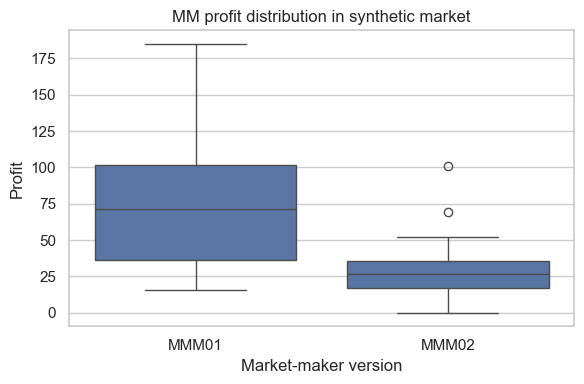

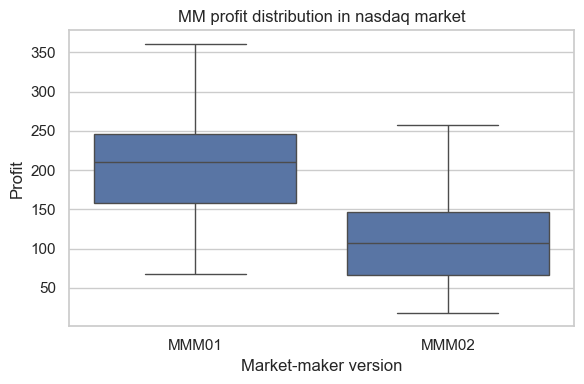

In [10]:
sns.set(style="whitegrid")

for market_id in MARKETS:
    fig, ax = plt.subplots(figsize=(6, 4))
    subset = all_results_df[all_results_df["market_id"] == market_id]

    # you can switch between boxplot and violinplot if you prefer
    sns.boxplot(
        data=subset,
        x="mm_version",
        y="profit",
        ax=ax,
    )

    ax.set_title(f"MM profit distribution in {market_id} market")
    ax.set_xlabel("Market-maker version")
    ax.set_ylabel("Profit")

    plt.tight_layout()
    plt.show()


## Hypothesis testing

In [11]:
def one_sided_t_test_mmm02_greater_mmm01(df, markets):
    """
    For each market, test:
      H0: mean(MMM02) <= mean(MMM01)
      H1: mean(MMM02)  > mean(MMM01)

    We compute a two-sided Welch t-test and then convert to a one-sided p-value.
    """
    rows = []

    for market_id in markets:
        subset = df[df["market_id"] == market_id]

        profits_01 = subset[subset["mm_version"] == "MMM01"]["profit"].values
        profits_02 = subset[subset["mm_version"] == "MMM02"]["profit"].values

        # Welch t-test (does not assume equal variance)
        t_stat, p_two_sided = stats.ttest_ind(
            profits_02,
            profits_01,
            equal_var=False,
        )

        # Convert to one-sided p-value for H1: mu_02 > mu_01
        if t_stat > 0:
            p_one_sided = p_two_sided / 2.0
        else:
            p_one_sided = 1.0 - p_two_sided / 2.0

        rows.append({
            "market_id": market_id,
            "t_stat": t_stat,
            "p_two_sided": p_two_sided,
            "p_one_sided_H1_mu02_gt_mu01": p_one_sided,
        })

    return pd.DataFrame(rows)


ttest_results_df = one_sided_t_test_mmm02_greater_mmm01(
    df=all_results_df,
    markets=MARKETS,
)

print("One-sided t-test results (H1: mean profit MMM02 > MMM01):")
ttest_results_df


One-sided t-test results (H1: mean profit MMM02 > MMM01):


,market_id,t_stat,p_two_sided,p_one_sided_H1_mu02_gt_mu01
0,synthetic,-5.436827,0.000002,0.999999
1,nasdaq,-5.218293,0.000003,0.999999


### Interpreting the hypothesis tests

For each market, we test:

- **H0**: mean profit of MMM02 ≤ mean profit of MMM01  
- **H1**: mean profit of MMM02 > mean profit of MMM01  

We use a one-sided Welch t-test, and report:

- `t_stat`: the t statistic (positive if MMM02 has higher sample mean than MMM01)
- `p_one_sided_H1_mu02_gt_mu01`: the one-sided p-value for H1

**Interpretation:**

- If `p_one_sided < 0.05`, we reject H0 at the 5% significance level and conclude that  
  **MMM02 significantly outperforms MMM01** in that market.
- If `p_one_sided >= 0.05`, we **do not** reject H0; the data do not provide sufficient
  statistical evidence that MMM02 has a higher mean profit than MMM01 in that market.


### No.1 result（Mean-Reversion）
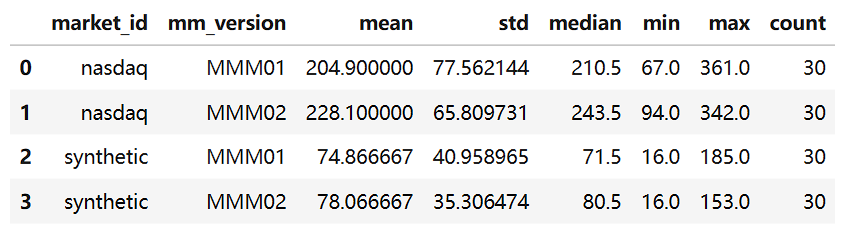

# Plus

In [13]:
import os
import csv


def make_session_id(market_id, mm_version, run_id, params=None, data_dir=None):
    """
    Reconstruct session_id used in Q4 for a given (market_id, mm_version, run_id).
    Assumes the naming convention from the Q4 notebook.
    """
    if params is None:
        params = MMM_PARAMS
    if data_dir is None:
        data_dir = Q4DATA_DIR

    label = (
        f"Q4_{market_id}_{mm_version}_"
        f"n{params['n_past_trades']}_"
        f"bp{params['bid_percent']:.2f}_"
        f"ad{params['ask_delta']}_"
        f"run{run_id:03d}"
    )
    sess_id = os.path.join(data_dir, label)
    return sess_id


def parse_mm_trades_from_blotter(blotter_path, mmm_tid="M00"):
    """
    Parse the blotter CSV and return:
      - list of (time, price) for the MM's trades
      - integer number of trades
    """
    trades = []

    if not os.path.exists(blotter_path):
        return trades, 0

    with open(blotter_path, newline="") as f:
        reader = csv.reader(f)
        rows = list(reader)

    i = 0
    while i < len(rows):
        row = rows[i]
        if not row:
            i += 1
            continue

        tid = row[0].strip()
        # row format: tid, n_trades, ...
        try:
            n_trades = int(row[1])
        except (ValueError, IndexError):
            n_trades = 0

        if tid == mmm_tid:
            # next n_trades rows contain the trades
            for j in range(i + 1, i + 1 + n_trades):
                if j >= len(rows):
                    break
                trow = rows[j]
                # typical format: time, price, qty, ...
                try:
                    t = float(trow[0])
                    p = float(trow[1])
                except (ValueError, IndexError):
                    continue
                trades.append((t, p))
            i += 1 + n_trades
        else:
            # skip other traders' trades
            i += 1 + n_trades

    return trades, len(trades)


In [14]:
from tqdm.notebook import tqdm  # if tqdm already imported you can skip this import

def attach_num_trades_to_results(results_df):
    """
    For each row in all_results_df, read the corresponding blotter file
    and count how many trades the market-maker executed in that run.
    """
    num_trades_list = []

    for idx, row in tqdm(results_df.iterrows(), total=len(results_df), desc="Counting MM trades"):
        market_id = row["market_id"]
        mm_version = row["mm_version"]
        run_id = int(row["run_id"])

        sess_id = make_session_id(market_id, mm_version, run_id)
        blotter_path = sess_id + "_blotters.csv"

        _, n_trades = parse_mm_trades_from_blotter(blotter_path, mmm_tid="M00")
        num_trades_list.append(n_trades)

    results_with_trades = results_df.copy()
    results_with_trades["num_trades"] = num_trades_list
    return results_with_trades


results_with_trades = attach_num_trades_to_results(all_results_df)
results_with_trades.head()


Counting MM trades:   0%|          | 0/120 [00:00<?, ?it/s]

,market_id,trader_type,mm_version,run_id,profit,num_trades
0,synthetic,market_maker,MMM01,0,104.0,0
1,synthetic,market_maker,MMM01,1,122.0,0
2,synthetic,market_maker,MMM01,2,185.0,0
3,synthetic,market_maker,MMM01,3,96.0,0
4,synthetic,market_maker,MMM01,4,69.0,0


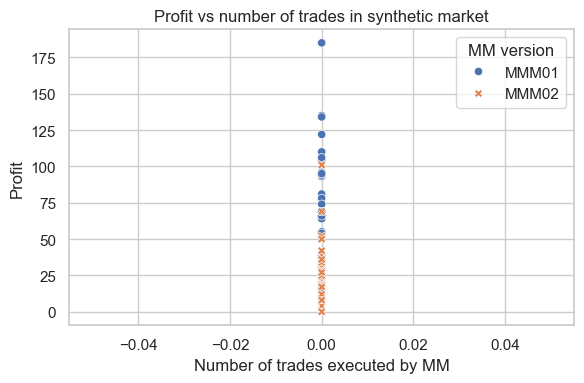

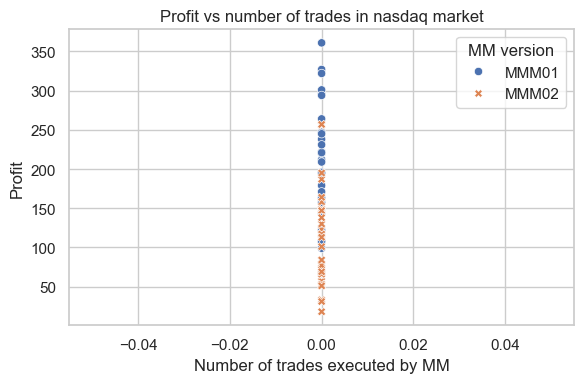

,market_id,mm_version,mean_profit,std_profit,mean_num_trades,std_num_trades,count
0,nasdaq,MMM01,204.900000,77.562144,0.0,0.0,30
1,nasdaq,MMM02,110.766667,61.207777,0.0,0.0,30
2,synthetic,MMM01,74.866667,40.958965,0.0,0.0,30
3,synthetic,MMM02,29.166667,21.023933,0.0,0.0,30


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Scatter plots: profit vs number of trades, split by market and MM version
for market_id in MARKETS:
    fig, ax = plt.subplots(figsize=(6, 4))
    subset = results_with_trades[results_with_trades["market_id"] == market_id]

    sns.scatterplot(
        data=subset,
        x="num_trades",
        y="profit",
        hue="mm_version",
        style="mm_version",
        ax=ax,
    )
    ax.set_title(f"Profit vs number of trades in {market_id} market")
    ax.set_xlabel("Number of trades executed by MM")
    ax.set_ylabel("Profit")
    plt.legend(title="MM version")
    plt.tight_layout()
    plt.show()

# Simple summary: average num_trades and profit by market & MM
summary_trades = (
    results_with_trades
    .groupby(["market_id", "mm_version"])
    .agg(
        mean_profit=("profit", "mean"),
        std_profit=("profit", "std"),
        mean_num_trades=("num_trades", "mean"),
        std_num_trades=("num_trades", "std"),
        count=("profit", "count"),
    )
    .reset_index()
    .sort_values(["market_id", "mm_version"])
)

summary_trades


In [16]:
# Find the worst MMM02 run (lowest profit)
mmm02_only = results_with_trades[results_with_trades["mm_version"] == "MMM02"]
worst_idx = mmm02_only["profit"].idxmin()
worst_row = results_with_trades.loc[worst_idx]

worst_row


market_id         synthetic
trader_type    market_maker
mm_version            MMM02
run_id                   20
profit                  0.0
num_trades                0
Name: 80, dtype: object

In [17]:
# Print a small snippet of the blotter for this worst MMM02 run
market_id = worst_row["market_id"]
run_id = int(worst_row["run_id"])
mm_version = worst_row["mm_version"]

sess_id = make_session_id(market_id, mm_version, run_id)
blotter_path = sess_id + "_blotters.csv"

print("Worst MMM02 run blotter path:", blotter_path)

# show the first ~40 lines
if os.path.exists(blotter_path):
    with open(blotter_path, newline="") as f:
        for i, line in enumerate(f):
            print(line.strip())
            if i >= 40:
                break
else:
    print("Blotter file not found.")


Worst MMM02 run blotter path: Q4data\Q4_synthetic_MMM02_n7_bp0.97_ad10_run020_blotters.csv
B00, 21
B00, Trade, 10.863, 183, S09, B00, 1
B00, Trade, 54.667, 202, B00, S11, 1
B00, Trade, 75.804, 188, S05, B00, 1
B00, Trade, 109.451, 189, S01, B00, 1
B00, Trade, 204.980, 194, B00, S24, 1
B00, Trade, 238.902, 203, S21, B00, 1
B00, Trade, 260.059, 187, S23, B00, 1
B00, Trade, 302.176, 201, S05, B00, 1
B00, Trade, 316.667, 189, S22, B00, 1
B00, Trade, 357.784, 193, S22, B00, 1
B00, Trade, 396.961, 181, B00, S11, 1
B00, Trade, 541.706, 184, B00, S21, 1
B00, Trade, 579.314, 196, S24, B00, 1
B00, Trade, 676.608, 183, S05, B00, 1
B00, Trade, 694.961, 185, B00, S05, 1
B00, Trade, 726.804, 180, S11, B00, 1
B00, Trade, 739.980, 188, S22, B00, 1
B00, Trade, 818.098, 188, B00, S08, 1
B00, Trade, 828.824, 191, S15, B00, 1
B00, Trade, 859.725, 184, S14, B00, 1
B00, Trade, 899.941, 183, S11, B00, 1
B01, 5
B01, Trade, 722.725, 185, B01, S21, 1
B01, Trade, 782.314, 183, B01, S02, 1
B01, Trade, 825.490, 19

In [18]:
def plot_mm_trade_prices(market_id, mm_version, run_id, title_suffix=""):
    """
    Plot the sequence of trade prices for the MM in a given run.
    x-axis: trade index
    y-axis: trade price
    """
    sess_id = make_session_id(market_id, mm_version, run_id)
    blotter_path = sess_id + "_blotters.csv"
    trades, n_trades = parse_mm_trades_from_blotter(blotter_path, mmm_tid="M00")

    if n_trades == 0:
        print("No trades for", market_id, mm_version, "run", run_id)
        return

    times = [t for (t, p) in trades]
    prices = [p for (t, p) in trades]

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(range(n_trades), prices, marker="o")
    ax.set_title(f"MM {mm_version} trade prices in {market_id} run {run_id} {title_suffix}")
    ax.set_xlabel("Trade index")
    ax.set_ylabel("Trade price")
    plt.tight_layout()
    plt.show()


# Example: plot worst MMM02 run's trade prices
plot_mm_trade_prices(
    market_id=worst_row["market_id"],
    mm_version="MMM02",
    run_id=int(worst_row["run_id"]),
    title_suffix="(worst MMM02 run)"
)


No trades for synthetic MMM02 run 20
